In [1]:
import os 
from langgraph.graph import START,END,StateGraph
from langgraph.graph.message import add_messages
from langchain_groq.chat_models import ChatGroq
from typing import Annotated
from typing_extensions import TypedDict
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

#tools 
from langgraph.prebuilt import ToolNode,tools_condition


In [2]:
groq_api_key = ""
langchain_Api_key = ""
langchain_tracking_v2= "true"
langchian_project  = "CourseLanggraph"



In [3]:
## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=500)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)


In [4]:
api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

In [5]:
wiki_tool.invoke("Who is father of AI?")

'Page: Artificial intelligence\nSummary: Artificial intelligence (AI), in its broadest sense, is intelligence exhibited by machines, particularly computer systems. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals. Such machines may be called AIs.\nSome high-profile applications of AI include advanced w'

In [6]:
arxiv_tool.invoke("Explain Attention is All You Need")

'Published: 2018-07-02\nTitle: The Matrix Calculus You Need For Deep Learning\nAuthors: Terence Parr, Jeremy Howard\nSummary: This paper is an attempt to explain all the matrix calculus you need in order\nto understand the training of deep neural networks. We assume no math knowledge\nbeyond what you learned in calculus 1, and provide links to help you refresh\nthe necessary math where needed. Note that you do not need to understand this\nmaterial before you start learning to train and use deep learning'

In [7]:
class State(TypedDict):
    messages : Annotated[list,add_messages]

In [8]:
graphbuilder = StateGraph(State)


In [9]:
llm = ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

In [10]:
tools = [wiki_tool]

In [11]:
llm_tools = llm.bind_tools(tools=tools)

In [22]:
def chatbot(state:State):
    return {"messags":[llm_tools.invoke(state["messages"])]}

"""
def chatbot(state: State):
    response = llm_tools.invoke(state["messages"])
    state["messages"].append(("assistant", response))  # Ensure we write to 'messages'
    return state

"""

'\ndef chatbot(state: State):\n    response = llm_tools.invoke(state["messages"])\n    state["messages"].append(("assistant", response))  # Ensure we write to \'messages\'\n    return state\n\n'

In [13]:
graphbuilder.add_node("chatbot",chatbot)

In [14]:
tool_node = ToolNode(tools=tools)
graphbuilder.add_node("tools",tool_node)

In [15]:
graphbuilder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

In [16]:
graphbuilder.add_edge("tools","chatbot")
graphbuilder.add_edge(START,"chatbot")

In [17]:
graph = graphbuilder.compile()

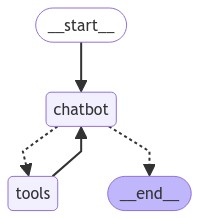

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [23]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.


ValidationError: 2 validation errors for AIMessage
content
  str type expected (type=type_error.str)
content
  value is not a valid list (type=type_error.list)

In [24]:
events.close

<generator object Pregel.stream at 0x0000023B6E4ACC80>